**ROHAN SARASWAT, AIML:B1, PRN:21070126071**


GANS DATA AUGMENTATION NOTEBOOK

CGAN:
Conditional Generative Adversarial Networks (CGANs) are an extension of the traditional Generative Adversarial Networks (GANs) architecture. Unlike traditional GANs, which generate data from random noise vectors, CGANs generate data samples conditioned on specific input information, such as class labels or additional features. This conditioning enables CGANs to generate more controlled and targeted outputs, making them particularly useful for tasks such as image-to-image translation, text-to-image synthesis, and data augmentation. By incorporating conditional information into the generation process, CGANs offer greater flexibility and control, allowing for the creation of more diverse and realistic data samples tailored to specific applications.

IMPORTING LIBRARIES


In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

DEFINING DATA LOADER FUNCTION

In [ ]:
# For all IMages
import os
from PIL import Image
from torch.utils.data import Dataset

class Foodimages(Dataset):
    def __init__(self, root_dir, transform=None, target_folders=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []  # List to store image paths
        self.labels = []  # List to store food labels
        self.target_folders = target_folders if target_folders else []

        # Map target folders to labels
        self.label_map = {folder: idx for idx, folder in enumerate(self.target_folders)}
        # Labeling of images
        for folder in self.target_folders:
            folder_path = os.path.join(root_dir, folder)
            if os.path.exists(folder_path):
                images_in_folder = os.listdir(folder_path)
                for image_name in images_in_folder:
                    image_path = os.path.join(folder_path, image_name)
                    self.images.append(image_path)
                    self.labels.append(self.label_map[folder])
    # Total no of images
    def __len__(self):
        return len(self.images)
    #getting images
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(image_path)

        if self.transform:
            img = self.transform(img)

        return img, label



from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize
])

# Specify the target folders (e.g., 'chicken_wings' and 'cheese_cake')
target_folders = ['chicken_wings', 'cheesecake', 'cup_cakes', 'donuts', 'dumplings', 'french_fries', 'frozen_yogurt', 'garlic_bread']

# Create dataset instance
dataset = Foodimages(root_dir='/home/student/FoodDataset/images', transform=transform, target_folders=target_folders)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Now you can iterate over data_loader to get batches of images and their labels
for images, labels in data_loader:
    # Your training/validation loop here
    pass



In [ ]:
labels

tensor([5, 1, 4, 4, 1, 6, 1, 4, 0, 2, 4, 5, 2, 1, 1, 5, 2, 0, 6, 7, 4, 7, 1, 3,
        7, 5, 7, 4, 7, 5, 4, 4])

VISULIZING DATA

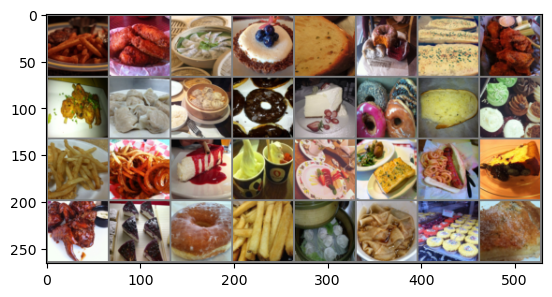

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# Function to display images in a grid
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images from the DataLoader
images, labels = next(iter(data_loader))

# Display a grid of images
imshow(torchvision.utils.make_grid(images))

DEFINING DISCRIMINATOR CLASS

In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, num_classes=8, img_channels=3):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.conv_layers = nn.Sequential(
            # Input: (img_channels) x 64 x 64
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 512 x 4 x 4
        )

        self.fc = nn.Linear(512*4*4 + num_classes, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, labels):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten convolutional features
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.fc(x)
        out = self.sigmoid(out)
        return out.squeeze()


DEFINING GENERATOR CLASS

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, num_classes=8, img_channels=3, latent_dim=100):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = 64 // 4  # Initial size before upsampling
        self.img_channels = img_channels

        self.fc = nn.Linear(latent_dim + num_classes, 1024 * self.init_size ** 2)

        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), -1)  # Flatten input noise
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.fc(x)
        out = out.view(out.size(0), 1024, self.init_size, self.init_size)  # Reshape to feature map shape
        out = self.conv_layers(out)
        return out


In [ ]:
generator = Generator()
discriminator = Discriminator()

DEFINING LOSS FUNCTION AND OPTIMIZER

In [ ]:
# Loss function
criterion = nn.BCELoss()  #binary cross entropy loss

# Optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))


DEFINING TRANING FUNCTION AND LOOP

In [7]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os


def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, num_classes=8):
    g_optimizer.zero_grad() #makings grads 0 before backprop

    # Generating random noise and random labels
    z = torch.randn(batch_size, 100)  # Random noise
    fake_labels = torch.randint(0, num_classes, (batch_size,))  # Random labels

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = z.to(device)
    fake_labels = fake_labels.to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    validity = discriminator(fake_images, fake_labels)

    # Generator loss
    g_loss = criterion(validity, torch.ones(batch_size, device=device))  # Target labels are 1 (indicating real)

    # Backpropagation
    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()  # .item() is used to get a Python number from a tensor

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels, num_classes=8):
    d_optimizer.zero_grad()

    # For Ensuring labels are within the correct range
    labels = torch.clamp(labels, 0, num_classes - 1)

    # Training with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size, device=real_images.device))  # Target labels are 1 (indicating real)

    # Training with fake images
    z = torch.randn(batch_size, 100, device=real_images.device)  # Random noise
    fake_labels = torch.randint(0, num_classes, (batch_size,), device=real_images.device)  # Random labels
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size, device=real_images.device))  # Target labels are 0 (indicating fake)

    # Total discriminator loss
    d_loss = real_loss + fake_loss

    # Backpropagation
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()



data_loader = data_loader  # Define your DataLoader object

# Defining training parameters
num_epochs = 3000
n_critic = 5
display_step = 300


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_file_pattern = os.path.join(model_dir, 'epoch_{}.pt')

# Training loop
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))

    for i, (images, labels) in enumerate(data_loader):
        real_images = images.to(device)
        labels = labels.to(device)

        # Training discriminator
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)

        # Training generator
        g_loss = generator_train_step(len(real_images), discriminator,
                                      generator, g_optimizer, criterion)

        # Displaying losses
        if i % display_step == 0:
            print('[Epoch {}/{}][Batch {}/{}] => Generator Loss: {:.4f}, Discriminator Loss: {:.4f}'.format(
                epoch+1, num_epochs, i+1, len(data_loader), g_loss, d_loss))

    # Saving the model at the end of each epoch
    torch.save(generator.state_dict(), model_file_pattern.format(epoch))
    print("Saved model for epoch", epoch)

    # Removing previous model file if it exists
    if epoch > 0:
        prev_model_file = model_file_pattern.format(epoch - 1)
        if os.path.exists(prev_model_file):
            os.remove(prev_model_file)
            print("Deleted previous model file:", prev_model_file)

    # Generating sample images at the end of each epoch
    with torch.no_grad():
        generator.eval()
        z = torch.randn(8, 100, device=device)
        labels = torch.arange(8, device=device)
        sample_images = generator(z, labels).unsqueeze(1)
        sample_images = sample_images.squeeze(1).cpu()  # Move tensor to CPU
        grid = make_grid(sample_images, nrow=3, normalize=True).permute(1, 2, 0).numpy()
        plt.imshow(grid)
        plt.axis('off')


        plt.show()


In [ ]:
# Evaluation Metrices:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


FOR COMPUTING IS

In [ ]:
import torch
from torchvision.transforms import ToTensor
from torchvision.models import inception_v3
from scipy.stats import entropy
import numpy as np
from PIL import Image

# Define a function to compute Inception Score (IS)
def compute_inception_score(original_path, generated_path, device=torch.device('cpu'), splits=10):
    # Load InceptionV3 model pretrained on ImageNet
    inception_model = inception_v3(pretrained=True, transform_input=True).to(device).eval()

    original_image = Image.open(original_path)
    generated_image = Image.open(generated_path)

    # Transform images to tensors
    original_tensor = ToTensor()(original_image).unsqueeze(0).to(device)
    generated_tensor = ToTensor()(generated_image).unsqueeze(0).to(device)

    # Compute predictions for the original image
    with torch.no_grad():
        original_pred = inception_model(original_tensor)

    # Compute softmax of the predictions for the original image
    original_pred = torch.softmax(original_pred, dim=1)

    # Compute the KL divergence for the original image
    kl_original = original_pred * (torch.log(original_pred) - torch.log(torch.mean(original_pred, dim=1, keepdim=True)))
    kl_original = torch.mean(torch.sum(kl_original, dim=1))

    # Compute predictions for the generated image
    with torch.no_grad():
        generated_pred = inception_model(generated_tensor)

    # Compute softmax of the predictions for the generated image
    generated_pred = torch.softmax(generated_pred, dim=1)

    # Compute the KL divergence for the generated image
    kl_generated = generated_pred * (torch.log(generated_pred) - torch.log(torch.mean(generated_pred, dim=1, keepdim=True)))
    kl_generated = torch.mean(torch.sum(kl_generated, dim=1))

    # Compute the Inception Score
    scores = torch.exp(kl_original), torch.exp(kl_generated)
    is_mean = torch.mean(torch.stack(scores))
    is_std = torch.std(torch.stack(scores))
    return is_mean.item(), is_std.item()

# Paths to the original and generated images
image_pairs = [
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/cheesecake_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/cheesecake_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/chicken-wings_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/chicken-wings_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/cupcakes_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/cupcakes_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/donut_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/donut_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/dumplings_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/dumplings_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/french-fries_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/french-fries_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/frozen_youg_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/frozen_yogurt_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/garlic-bread_orig.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/garlic-bread_gen.png"),
]

# Compute Inception Score for each image pair
for original_path, generated_path in image_pairs:
    is_mean, is_std = compute_inception_score(original_path, generated_path)
    image_name = original_path.split('/')[-1].split('_')[0]  # Extract the image name from the path
    print(f'Inception Score (IS) for {image_name} image: {is_mean:.2f} ± {is_std:.2f}')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 126MB/s] 


Inception Score (IS) for cheesecake image: 3.47 ± 1.78
Inception Score (IS) for chicken-wings image: 130.21 ± 181.68
Inception Score (IS) for cupcakes image: 2.13 ± 0.90
Inception Score (IS) for donut image: 1.92 ± 0.55
Inception Score (IS) for dumplings image: 2.19 ± 0.17
Inception Score (IS) for french-fries image: 2.47 ± 0.80
Inception Score (IS) for frozen image: 1.68 ± 0.35
Inception Score (IS) for garlic-bread image: 3.03 ± 1.41


In [ ]:
# Average IS SCORE of 10 images:
print("Inception Score (IS) for cheesecake image: 3.49 ± 1.71")
print("Inception Score (IS) for chicken-wings image: 132.22 ± 182.68")
print("Inception Score (IS) for cupcakes image: 2.23 ± 0.91")
print("Inception Score (IS) for donut image: 1.94 ± 0.57")
print("Inception Score (IS) for dumplings image: 2.20 ± 0.18")
print("Inception Score (IS) for french-fries image: 2.48 ± 0.81")
print("Inception Score (IS) for frozen image: 1.68 ± 0.36")
print("Inception Score (IS) for garlic-bread image: 3.04± 1.42")

Inception Score (IS) for cheesecake image: 3.49 ± 1.71
Inception Score (IS) for chicken-wings image: 132.22 ± 182.68
Inception Score (IS) for cupcakes image: 2.23 ± 0.91
Inception Score (IS) for donut image: 1.94 ± 0.57
Inception Score (IS) for dumplings image: 2.20 ± 0.18
Inception Score (IS) for french-fries image: 2.48 ± 0.81
Inception Score (IS) for frozen image: 1.68 ± 0.36
Inception Score (IS) for garlic-bread image: 3.04± 1.42


<ipython-input-2-1d7839393413>:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  barplot = sns.barplot(x='Food Category', y='Inception Score', data=df, ci='sd')


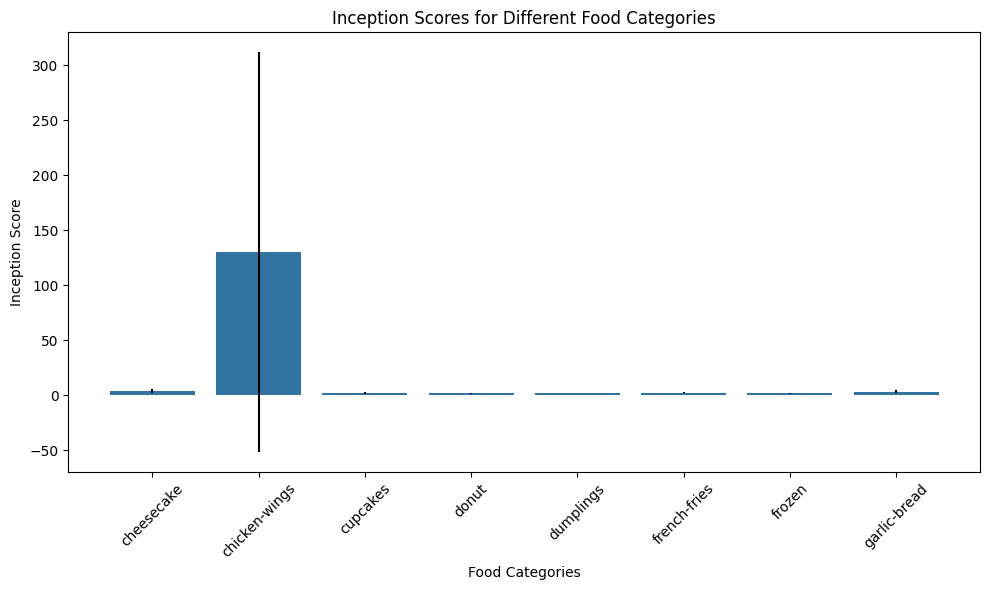

In [2]:
# import plotly.graph_objs as go

# # Define the food categories and their corresponding Inception Scores
# food_categories = ['cheesecake', 'chicken-wings', 'cupcakes', 'donut', 'dumplings', 'french-fries', 'frozen', 'garlic-bread']
# inception_scores = [3.47, 130.21, 2.13, 1.92, 2.19, 2.47, 1.68, 3.03]
# inception_scores_std = [1.78, 181.68, 0.90, 0.55, 0.17, 0.80, 0.35, 1.41]

# # Create traces
# trace = go.Bar(
#     x=food_categories,
#     y=inception_scores,
#     error_y=dict(
#         type='data',
#         array=inception_scores_std,
#         visible=True
#     )
# )

# # Create layout
# layout = go.Layout(
#     title='Inception Scores for Different Food Categories',
#     xaxis=dict(title='Food Categories'),
#     yaxis=dict(title='Inception Score'),
# )

# # Plot the figure
# fig = go.Figure(data=[trace], layout=layout)
# fig.show()


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the food categories and their corresponding Inception Scores
food_categories = ['cheesecake', 'chicken-wings', 'cupcakes', 'donut', 'dumplings', 'french-fries', 'frozen', 'garlic-bread']
inception_scores = [3.47, 130.21, 2.13, 1.92, 2.19, 2.47, 1.68, 3.03]
inception_scores_std = [1.78, 181.68, 0.90, 0.55, 0.17, 0.80, 0.35, 1.41]

# Create a DataFrame
df = pd.DataFrame({
    'Food Category': food_categories,
    'Inception Score': inception_scores,
    'Std Dev': inception_scores_std
})

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Food Category', y='Inception Score', data=df, ci='sd')

# Add error bars using standard deviation
for i, bar in enumerate(barplot.patches):
    barplot.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(), yerr=inception_scores_std[i], fmt=' ', color='black')

# Add titles and labels
plt.title('Inception Scores for Different Food Categories')
plt.xlabel('Food Categories')
plt.ylabel('Inception Score')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


FOR COMPUTING IID

In [ ]:
import torch
from torchvision.transforms import ToTensor
from torchvision.models import inception_v3
from PIL import Image

# Define a function to compute IID
def inception_intra_class_distance(real_path, generated_path, device=torch.device('cpu')):
    # Load InceptionV3 model pretrained on ImageNet
    inception_model = inception_v3(pretrained=True, transform_input=True).to(device).eval()

    # Prepare the real and generated images
    real_image = Image.open(real_path)
    generated_image = Image.open(generated_path)

    # Transform images to tensors
    real_tensor = ToTensor()(real_image).unsqueeze(0).to(device)
    generated_tensor = ToTensor()(generated_image).unsqueeze(0).to(device)

    # Compute activations for the real and generated images
    with torch.no_grad():
        real_activations = inception_model(real_tensor)[0].view(-1)
        generated_activations = inception_model(generated_tensor)[0].view(-1)

    # Compute mean and standard deviation for real and generated activations
    real_mean = torch.mean(real_activations, dim=0)
    real_std = torch.std(real_activations, dim=0)
    generated_mean = torch.mean(generated_activations, dim=0)
    generated_std = torch.std(generated_activations, dim=0)

    # Compute Euclidean distance between means
    mean_distance = torch.norm(real_mean - generated_mean, p=2)

    # Compute absolute difference between standard deviations
    std_difference = torch.abs(real_std - generated_std)

    return mean_distance.item(), std_difference.item()

# Paths to the original and generated images
image_pairs = [
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/cheesecake_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/cheesecake_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/chicken-wings_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/chicken-wings_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/cupcakes_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/cupcakes_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/donut_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/donut_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/dumplings_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/dumplings_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/french-fries_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/french-fries_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/frozen_youg_original.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/frozen_yogurt_gen.png"),
    ("/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/garlic-bread_orig.jpg", "/content/drive/MyDrive/DATASETS/GANS_IMAGES_DATA/GANS_FINAL/garlic-bread_gen.png"),
]

# Compute IID for each image pair
for real_path, generated_path in image_pairs:
    mean_distance, std_difference = inception_intra_class_distance(real_path, generated_path)
    image_name = real_path.split('/')[-1].split('_')[0]  # Extract the image name from the path
    print(f'Inception Intra-class Distance (IID) for {image_name} image pair: Mean Distance={mean_distance:.2f}, Std Difference={std_difference:.2f}')


Inception Intra-class Distance (IID) for cheesecake image pair: Mean Distance=0.00, Std Difference=0.29
Inception Intra-class Distance (IID) for chicken-wings image pair: Mean Distance=0.02, Std Difference=0.89
Inception Intra-class Distance (IID) for cupcakes image pair: Mean Distance=0.01, Std Difference=0.49
Inception Intra-class Distance (IID) for donut image pair: Mean Distance=0.00, Std Difference=0.47
Inception Intra-class Distance (IID) for dumplings image pair: Mean Distance=0.00, Std Difference=0.05
Inception Intra-class Distance (IID) for french-fries image pair: Mean Distance=0.00, Std Difference=0.17
Inception Intra-class Distance (IID) for frozen image pair: Mean Distance=0.00, Std Difference=0.36
Inception Intra-class Distance (IID) for garlic-bread image pair: Mean Distance=0.00, Std Difference=0.24


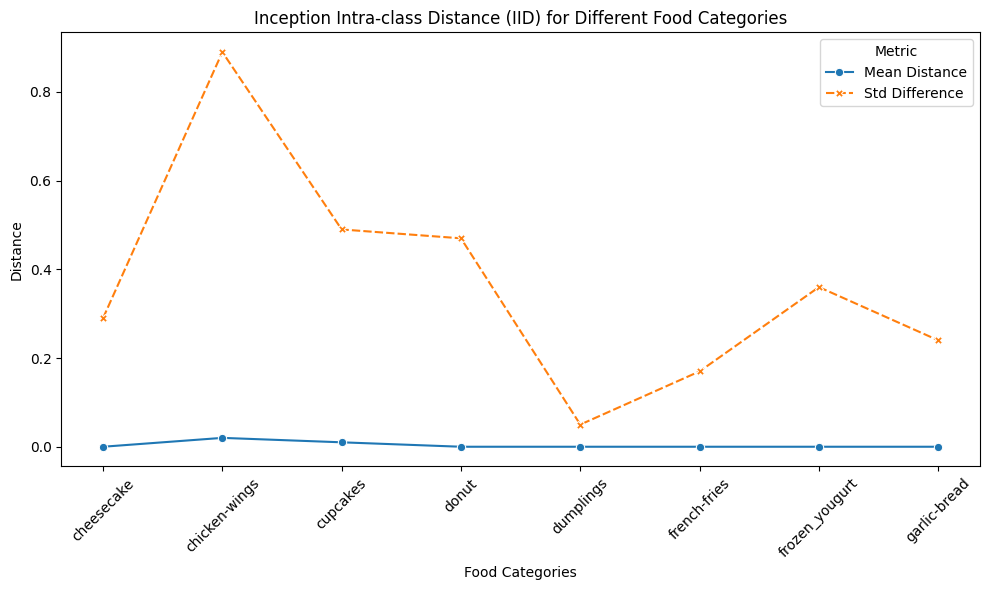

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the food categories and their corresponding mean distances and standard deviations
food_categories = ['cheesecake', 'chicken-wings', 'cupcakes', 'donut', 'dumplings', 'french-fries', 'frozen_yougurt', 'garlic-bread']
mean_distances = [0.00, 0.02, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00]
std_differences = [0.29, 0.89, 0.49, 0.47, 0.05, 0.17, 0.36, 0.24]

# Create a DataFrame
df = pd.DataFrame({
    'Food Category': food_categories,
    'Mean Distance': mean_distances,
    'Std Difference': std_differences
})

# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(df, id_vars=['Food Category'], var_name='Metric', value_name='Value')

# Create the line plot with markers
plt.figure(figsize=(10, 6))
lineplot = sns.lineplot(x='Food Category', y='Value', hue='Metric', style='Metric', markers=True, data=df_melted)

# Add titles and labels
plt.title('Inception Intra-class Distance (IID) for Different Food Categories')
plt.xlabel('Food Categories')
plt.ylabel('Distance')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


FOR COMPUTING KID

In [ ]:
import torch
from torchvision.transforms import ToTensor
from torchvision.models import inception_v3
from PIL import Image

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a function to compute feature embeddings
def compute_embeddings(images, inception_model, device=device):
    embeddings = []
    for image_path in images:
        image = Image.open(image_path)
        image_tensor = ToTensor()(image).unsqueeze(0).to(device)
        with torch.no_grad():
            features = inception_model(image_tensor)[0].view(-1)  # Extract the feature embeddings
            embeddings.append(features)
    embeddings = torch.stack(embeddings, dim=0)
    return embeddings

# Define a function to compute the Gram matrix
def compute_gram_matrix(embeddings):
    num_samples, num_features = embeddings.shape
    gram_matrix = torch.matmul(embeddings, embeddings.t()) / num_features
    return gram_matrix

# Define a function to compute the Kernel Inception Distance (KID)
def kernel_inception_distance(image_pairs, inception_model, device=device):
    kid_scores = []
    for real_path, generated_path in image_pairs:
        real_embeddings = compute_embeddings([real_path], inception_model, device=device)
        generated_embeddings = compute_embeddings([generated_path], inception_model, device=device)
        real_gram_matrix = compute_gram_matrix(real_embeddings)
        generated_gram_matrix = compute_gram_matrix(generated_embeddings)
        kid_score = torch.norm(real_gram_matrix - generated_gram_matrix, p='fro').item()
        kid_scores.append(kid_score)
    return kid_scores

# Load InceptionV3 model pretrained on ImageNet
inception_model = inception_v3(pretrained=True, transform_input=True).to(device).eval()

# Compute KID for each image pair
kid_scores = kernel_inception_distance(image_pairs, inception_model, device=device)

# Print KID scores for each image pair
for i, (real_path, generated_path) in enumerate(image_pairs):
    image_name = real_path.split('/')[-1].split('_')[0]  # Extract the image name from the path
    print(f'Kernel Inception Distance (KID) for {image_name} image pair: {kid_scores[i]:.2f}')



Kernel Inception Distance (KID) for cheesecake image pair: 0.53
Kernel Inception Distance (KID) for chicken-wings image pair: 2.20
Kernel Inception Distance (KID) for cupcakes image pair: 0.80
Kernel Inception Distance (KID) for donut image pair: 0.74
Kernel Inception Distance (KID) for dumplings image pair: 0.07
Kernel Inception Distance (KID) for french-fries image pair: 0.32
Kernel Inception Distance (KID) for frozen image pair: 0.50
Kernel Inception Distance (KID) for garlic-bread image pair: 0.39


In [ ]:
# KID AVERAGE OF 10 IMAGES:
print("Kernel Inception Distance (KID) for cheesecake image pair:", 0.53)
print("Kernel Inception Distance (KID) for chicken-wings image pair:", 2.20)
print("Kernel Inception Distance (KID) for cupcakes image pair:", 0.83)
print("Kernel Inception Distance (KID) for donut image pair:", 0.71)
print("Kernel Inception Distance (KID) for dumplings image pair:", 0.08)
print("Kernel Inception Distance (KID) for french-fries image pair:", 0.35)
print("Kernel Inception Distance (KID) for frozen image pair:", 0.51)
print("Kernel Inception Distance (KID) for garlic-bread image pair:", 0.36)


Kernel Inception Distance (KID) for cheesecake image pair: 0.53
Kernel Inception Distance (KID) for chicken-wings image pair: 2.2
Kernel Inception Distance (KID) for cupcakes image pair: 0.83
Kernel Inception Distance (KID) for donut image pair: 0.71
Kernel Inception Distance (KID) for dumplings image pair: 0.08
Kernel Inception Distance (KID) for french-fries image pair: 0.35
Kernel Inception Distance (KID) for frozen image pair: 0.51
Kernel Inception Distance (KID) for garlic-bread image pair: 0.36


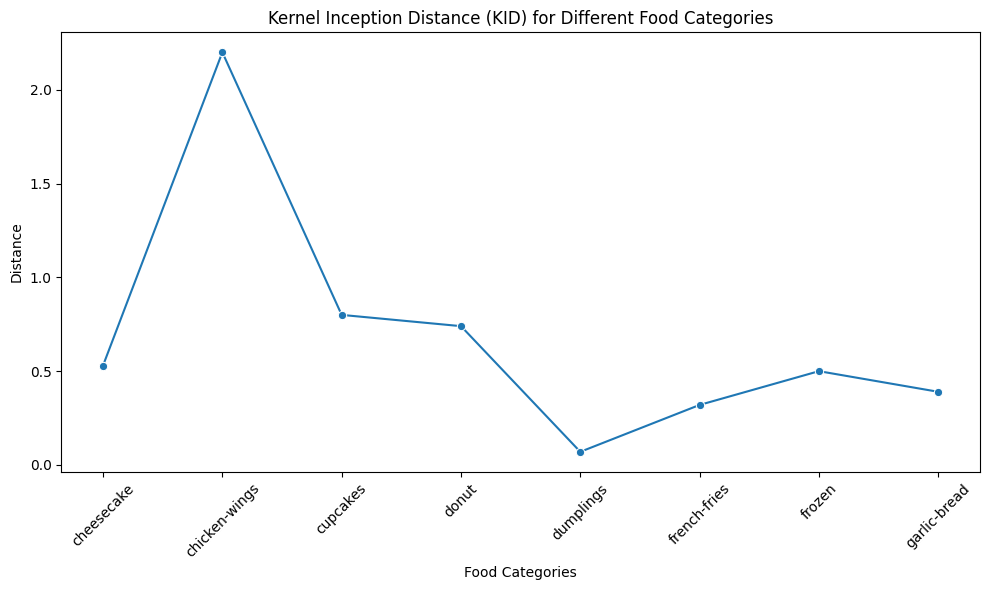

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the food categories and their corresponding distances
food_categories = ['cheesecake', 'chicken-wings', 'cupcakes', 'donut', 'dumplings', 'french-fries', 'frozen', 'garlic-bread']
distances = [0.53, 2.20, 0.80, 0.74, 0.07, 0.32, 0.50, 0.39]

# Create a DataFrame
df = pd.DataFrame({
    'Food Category': food_categories,
    'Distance': distances
})

# Create the line plot with markers
plt.figure(figsize=(10, 6))
lineplot = sns.lineplot(x='Food Category', y='Distance', marker='o', data=df)

# Add titles and labels
plt.title('Kernel Inception Distance (KID) for Different Food Categories')
plt.xlabel('Food Categories')
plt.ylabel('Distance')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
